In [11]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
from prettytable import PrettyTable

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB 
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [12]:
tamil_data = pd.read_csv("tamil_train.csv")
tamil_val = pd.read_csv("tamil_val.csv")

tamil_data = tamil_data[~((tamil_data["Tag"] == "sym") & (tamil_data["Word"] != "*"))].replace("*", "asterisk").fillna("")
tamil_val = tamil_val[~((tamil_val["Tag"] == "sym") & (tamil_val["Word"] != "*"))].replace("*", "asterisk").fillna("")


kanada_data = pd.read_csv("kn_train.csv")
kanada_val = pd.read_csv("kn_val.csv")
kanada_data = pd.concat([kanada_data, kanada_val], axis=0)

tulu_data = pd.read_csv("tulu_train.csv")
tulu_val = pd.read_csv("tulu_val.csv")
tulu_data = pd.concat([tulu_data, tulu_val], axis=0)

malayalam_data = pd.read_csv("mal_train.csv")
malayalam_val = pd.read_csv("mal_val.csv")
malayalam_data = pd.concat([malayalam_data, malayalam_val], axis=0)

# Oversampling "en", "other", "mixed" categories to improve accuracy of those categories
tamil_en = tamil_data[tamil_data["Tag"] == "en"]
tamil_other = tamil_data[tamil_data["Tag"] == "Other"]
tamil_mixed = tamil_data[tamil_data["Tag"] == "tmen"]

# Names from other languages are also included (More the data, Better the performance)
tamil_name = tamil_data[tamil_data["Tag"] == "name"]
kanada_name = kanada_data[kanada_data["Tag"] == "name"]
tulu_name = tulu_data[tulu_data["Language"] == "Name"]
tulu_name.columns = ["Word", "Tag"]
tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "name")
malayalam_name = malayalam_data[malayalam_data["Tag"] == "NAME"]
malayalam_name["Tag"] = malayalam_name["Tag"].replace("NAME", "name")

# Locations from other languages are also included
tamil_loc = tamil_data[tamil_data["Tag"] == "Location"]
kanada_loc = kanada_data[kanada_data["Tag"] == "location"]
kanada_loc["Tag"] = kanada_loc["Tag"].replace("location", "Location")
tulu_loc = tulu_data[tulu_data["Language"] == "Location"]
tulu_loc.columns = ["Word", "Tag"]
malayalam_loc = malayalam_data[malayalam_data["Tag"] == "PLACE"]
malayalam_loc["Tag"] = malayalam_loc["Tag"].replace("PLACE", "Location")

# Combining all the data needed for training
tamil_data = pd.concat([tamil_data, tamil_en, tamil_mixed, kanada_loc, kanada_name, tamil_mixed, tamil_name, tulu_loc, malayalam_loc])
tamil_data_with_val = pd.concat([tamil_data, tamil_val])

# Removing some unknown Tag present in the given dataset 
tamil_data["Tag"] = np.where(tamil_data["Tag"].isin(["tm", "en", "tmen", "sym", "name", "Other", "Location"]), tamil_data["Tag"], "Other")
tamil_data_with_val["Tag"] = np.where(tamil_data_with_val["Tag"].isin(["tm", "en", "tmen", "sym", "name", "Other", "Location"]), tamil_data_with_val["Tag"], "Other")

C:\Users\justa\AppData\Local\Temp\ipykernel_12276\465433341.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tulu_name["Tag"] = tulu_name["Tag"].replace("Name", "name")
C:\Users\justa\AppData\Local\Temp\ipykernel_12276\465433341.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malayalam_name["Tag"] = malayalam_name["Tag"].replace("NAME", "name")
C:\Users\justa\AppData\Local\Temp\ipykernel_12276\465433341.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [13]:
tamil_data["Tag"].value_counts()

Tag
tm          7064
en          5526
tmen        3765
name        3679
sym         1126
Location     828
Other        103
Name: count, dtype: int64

In [14]:
tamil_data_with_val["Tag"].value_counts()

Tag
tm          8064
en          6022
tmen        3909
name        3839
sym         1309
Location     828
Other        104
Name: count, dtype: int64

In [15]:
tamil_data.describe()

,Word,Tag
count,22091,22091
unique,7142,7
top,asterisk,tm
freq,1203,7064


In [16]:
tamil_val.describe()

,Word,Tag
count,1984,1984
unique,1297,6
top,asterisk,tm
freq,183,1000


<Axes: xlabel='Tag', ylabel='Count'>

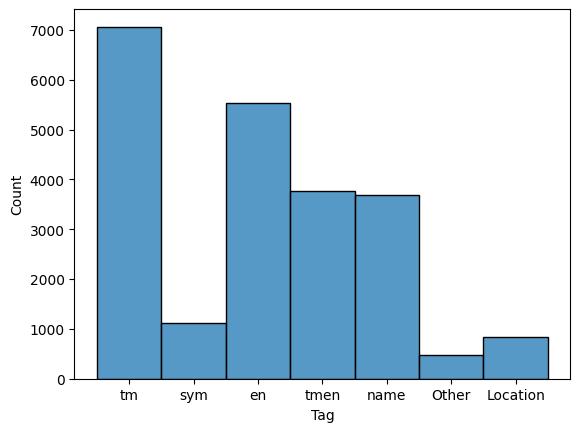

In [7]:
sb.histplot(tamil_data["Tag"])

In [8]:
countVectorizer = CountVectorizer(ngram_range=(1,5), analyzer='char')
tfidf = TfidfVectorizer(ngram_range=(1,5),analyzer='char')
kf = KFold(n_splits=10, shuffle=True, random_state=42)

model1 = MultinomialNB()
model2 = MultinomialNB()

model3 = LogisticRegression(solver='newton-cg', max_iter=2000)
model4 = LogisticRegression(solver='newton-cg', max_iter=2000)

model5 = svm.SVC()
model6 = svm.SVC()

model8 = DecisionTreeClassifier(random_state=42)
model9 = DecisionTreeClassifier(random_state=42)

model7 = VotingClassifier(
    estimators=[
        ('dtc', model8), 
        ('lr', model3), 
        ('svm', model5),
    ],
    voting='hard'
)

acc = [[], [], [], [], [], [], [], []] 
f1 = [[], [], [], [], [], [], [], []]
pre = [[], [], [], [], [], [], [], []]
rec = [[], [], [], [], [], [], [], []]

f1_a = [[], [], [], [], [], [], [], []]

In [7]:
X = tamil_data_with_val["Word"]
Y = tamil_data_with_val["Tag"]

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    

    train_vect_count = countVectorizer.fit_transform(X_train)
    test_vect_count = countVectorizer.transform(X_test)

    train_vect_tf = tfidf.fit_transform(X_train)
    test_vect_tf = tfidf.transform(X_test)


    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
    model1.fit(train_vect_count, y_train)
    model1_predict = model1.predict(test_vect_count)

    acc[0].append(accuracy_score(y_test, model1_predict))
    f1[0].append(f1_score(y_test, model1_predict, average='macro'))
    f1_a[0].append(f1_score(y_test, model1_predict, average='weighted'))
    pre[0].append(precision_score(y_test, model1_predict, average='macro', zero_division=np.nan))
    rec[0].append(recall_score(y_test, model1_predict, average='macro', zero_division=np.nan))


    # MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
    model2.fit(train_vect_tf, y_train)
    model2_predict = model2.predict(test_vect_tf)

    acc[1].append(accuracy_score(y_test, model2_predict))
    f1[1].append(f1_score(y_test, model2_predict, average='macro'))
    f1_a[1].append(f1_score(y_test, model2_predict, average='weighted'))
    pre[1].append(precision_score(y_test, model2_predict, average="macro", zero_division=np.nan))
    rec[1].append(recall_score(y_test, model2_predict, average="macro", zero_division=np.nan))

    # LOGISTIC REGRESSION using COUNT VECTORIZATION
    model3.fit(train_vect_count, y_train)
    model3_predict = model3.predict(test_vect_count)

    acc[2].append(accuracy_score(y_test, model3_predict))
    f1[2].append(f1_score(y_test, model3_predict, average="macro"))
    f1_a[2].append(f1_score(y_test, model3_predict, average="weighted"))
    pre[2].append(precision_score(y_test, model3_predict, average="macro", zero_division=np.nan))
    rec[2].append(recall_score(y_test, model3_predict, average="macro", zero_division=np.nan))

    # LOGISTIC REGRESSION using TFIDF VECTORIZATION
    model4.fit(train_vect_tf, y_train)
    model4_predict = model4.predict(test_vect_tf)

    acc[3].append(accuracy_score(y_test, model4_predict))
    f1[3].append(f1_score(y_test, model4_predict, average="macro"))
    f1_a[3].append(f1_score(y_test, model4_predict, average="weighted"))
    pre[3].append(precision_score(y_test, model4_predict, average="macro", zero_division=np.nan))
    rec[3].append(recall_score(y_test, model4_predict, average="macro", zero_division=np.nan))

    # SVM using COUNT VECTORIZATION
    model5.fit(train_vect_count, y_train)
    model5_predict = model5.predict(test_vect_count)

    acc[4].append(accuracy_score(y_test, model5_predict))
    f1[4].append(f1_score(y_test, model5_predict, average="macro"))
    f1_a[4].append(f1_score(y_test, model5_predict, average="weighted"))
    pre[4].append(precision_score(y_test, model5_predict, average="macro", zero_division=np.nan))
    rec[4].append(recall_score(y_test, model5_predict, average="macro", zero_division=np.nan))

    # SVM using TFIDF VECTORIZATION
    model6.fit(train_vect_tf, y_train)
    model6_predict = model6.predict(test_vect_tf)

    acc[5].append(accuracy_score(y_test, model6_predict))
    f1[5].append(f1_score(y_test, model6_predict, average="macro"))
    f1_a[5].append(f1_score(y_test, model6_predict, average="weighted"))
    pre[5].append(precision_score(y_test, model6_predict, average="macro", zero_division=np.nan))
    rec[5].append(recall_score(y_test, model6_predict, average="macro", zero_division=np.nan))

    # Decision Tree Classifier using COUNT VECTORIZATION
    model8.fit(train_vect_count, y_train)
    model8_predict = model8.predict(test_vect_count)

    acc[6].append(accuracy_score(y_test, model8_predict))
    f1[6].append(f1_score(y_test, model8_predict, average="macro"))
    f1_a[6].append(f1_score(y_test, model8_predict, average="weighted"))
    pre[6].append(precision_score(y_test, model8_predict, average="macro", zero_division=np.nan))
    rec[6].append(recall_score(y_test, model8_predict, average="macro", zero_division=np.nan))

    # Decision Tree Classifier using TFIDF VECTORIZATION
    model9.fit(train_vect_tf, y_train)
    model9_predict = model9.predict(test_vect_tf)

    acc[7].append(accuracy_score(y_test, model9_predict))
    f1[7].append(f1_score(y_test, model9_predict, average="macro"))
    f1_a[7].append(f1_score(y_test, model9_predict, average="weighted"))
    pre[7].append(precision_score(y_test, model9_predict, average="macro", zero_division=np.nan))
    rec[7].append(recall_score(y_test, model9_predict, average="macro", zero_division=np.nan))

In [8]:
MNB_count = ["MultinomialNB (Count)",sum(acc[0])/len(acc[0]), sum(f1[0])/len(f1[0]), sum(f1_a[0])/len(f1_a[0]),sum(pre[0])/len(pre[0]), sum(rec[0])/len(rec[0])]
MNB_tf = ["MultinomialNB (TFIDF)", sum(acc[1])/len(acc[1]), sum(f1[1])/len(f1[1]), sum(f1_a[1])/len(f1_a[1]), sum(pre[1])/len(pre[1]), sum(rec[1])/len(rec[1])]
Logistic_count = ["Logistic (Count)",sum(acc[2])/len(acc[2]), sum(f1[2])/len(f1[2]), sum(f1_a[2])/len(f1_a[2]), sum(pre[2])/len(pre[2]), sum(rec[2])/len(rec[2])]
Logistic_tf = ["Logistic (TFIDF)", sum(acc[3])/len(acc[3]), sum(f1[3])/len(f1[3]), sum(f1_a[3])/len(f1_a[3]), sum(pre[3])/len(pre[3]), sum(rec[3])/len(rec[3])]
SVM_count = ["SVM (Count)", sum(acc[4])/len(acc[4]), sum(f1[4])/len(f1[4]), sum(f1_a[4])/len(f1_a[4]), sum(pre[4])/len(pre[4]), sum(rec[4])/len(rec[4])]
SVM_tf = ["SVM (TFIDF)", sum(acc[5])/len(acc[5]), sum(f1[5])/len(f1[5]), sum(f1_a[5])/len(f1_a[5]), sum(pre[5])/len(pre[5]), sum(rec[5])/len(rec[5])]
DTC_count = ["DTC (Count)", sum(acc[6])/len(acc[6]), sum(f1[6])/len(f1[6]), sum(f1_a[6])/len(f1_a[6]), sum(pre[6])/len(pre[6]), sum(rec[6])/len(rec[6])]
DTC_tf = ["DTC (Count)", sum(acc[7])/len(acc[7]), sum(f1[7])/len(f1[7]), sum(f1_a[7])/len(f1_a[7]), sum(pre[7])/len(pre[7]), sum(rec[7])/len(rec[7])]

fields = ["Model Name", "Accuracy", "F1 Score (Macro)", "F1 Score (Weighted)", "Precision", "Recall Score"]

table = PrettyTable(field_names=fields)
table.add_rows([MNB_count, MNB_tf, Logistic_count, Logistic_tf, SVM_count, SVM_tf, DTC_count, DTC_tf])
table

Model Name,Accuracy,F1 Score (Macro),F1 Score (Weighted),Precision,Recall Score
MultinomialNB (Count),0.8499552408024778,0.8354737515867796,0.8487082198058111,0.8748591507158439,0.8139461440216355
MultinomialNB (TFIDF),0.832339230275462,0.7721682672734447,0.8263291140493767,0.892654232056419,0.7275106005743988
Logistic (Count),0.9386085419729,0.9368945413460479,0.938387211575105,0.9396807065587505,0.9355136612746244
Logistic (TFIDF),0.9030902725683092,0.8861684055770503,0.9021203219658822,0.9199642489175487,0.8625626281474312
SVM (Count),0.9259378463658505,0.9197304619722277,0.9255246129093082,0.9332407953311666,0.9098982347852396
SVM (TFIDF),0.9345622370042113,0.9322267869900289,0.9341936898596186,0.9417095517536012,0.9259207702027755
DTC (Count),0.9268778897583806,0.9263495897983077,0.9265643709129339,0.922364867296154,0.931650777655031
DTC (Count),0.9210328464677658,0.9200877253926485,0.9206171566909754,0.9168476323357915,0.9250763663543194


In [17]:
x_train = tamil_data["Word"]
y_train = tamil_data["Tag"]
x_test = tamil_val["Word"]
y_test = tamil_val["Tag"]

count_vec_train = countVectorizer.fit_transform(x_train)
tf_vec_train = tfidf.fit_transform(x_train)
count_vec_test = countVectorizer.transform(x_test)
tf_vec_test = tfidf.transform(x_test)

model7.fit(count_vec_train, y_train)
model7_predict = model7.predict(count_vec_test)

print(classification_report(y_test, model7_predict), "\n")

model7.fit(tf_vec_train, y_train)
model7_predict = model7.predict(tf_vec_test)

print(classification_report(y_test, model7_predict), "\n")

c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.20      1.00      0.33         1
          en       0.92      0.91      0.91       496
        name       0.77      0.76      0.76       160
         sym       1.00      1.00      1.00       183
          tm       0.94      0.94      0.94      1000
        tmen       0.85      0.84      0.85       144

    accuracy                           0.92      1984
   macro avg       0.67      0.78      0.69      1984
weighted avg       0.92      0.92      0.92      1984
 

              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.33      1.00      0.50         1
          en       0.88      0.91      0.90       496
        name       0.82      0.75      0.78       160
         sym       1.00      1.00      1.00       183
          tm       0.94      0.95      0.94      1000
        tmen       0.8

c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# result = pd.concat([x_test.reset_index(drop=True), pd.Series(model7_predict, name="Tag")], axis=1).replace("asterisk","*")
# result.to_csv('predictions.csv', index=False)

In [18]:
X_train = tamil_data["Word"]
y_train = tamil_data["Tag"]

X_test = tamil_val["Word"]
y_test = tamil_val["Tag"]

train_vect_count = countVectorizer.fit_transform(X_train)
test_vect_count = countVectorizer.transform(X_test)

train_vect_tf = tfidf.fit_transform(X_train)
test_vect_tf = tfidf.transform(X_test)


# MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
model1.fit(train_vect_count, y_train)
model1_predict = model1.predict(test_vect_count)
print("MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION")
print(classification_report(y_test, model1_predict), "\n\n")


# MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
model2.fit(train_vect_tf, y_train)
model2_predict = model2.predict(test_vect_tf)
print("MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION")
print(classification_report(y_test, model2_predict), "\n\n")


# LOGISTIC REGRESSION using COUNT VECTORIZATION
model3.fit(train_vect_count, y_train)
model3_predict = model3.predict(test_vect_count)
print("LOGISTIC REGRESSION using COUNT VECTORIZATION")
print(classification_report(y_test, model3_predict), "\n\n")


# LOGISTIC REGRESSION using TFIDF VECTORIZATION
model4.fit(train_vect_tf, y_train)
model4_predict = model4.predict(test_vect_tf)
print("LOGISTIC REGRESSION using TFIDF VECTORIZATION")
print(classification_report(y_test, model4_predict), "\n\n")

# SVM using COUNT VECTORIZATION
model5.fit(train_vect_count, y_train)
model5_predict = model5.predict(test_vect_count)
print("SVM using COUNT VECTORIZATION")
print(classification_report(y_test, model5_predict), "\n\n")

# SVM using TFIDF VECTORIZATION
model6.fit(train_vect_tf, y_train)
model6_predict = model6.predict(test_vect_tf)
print("SVM using TFIDF VECTORIZATION")
print(classification_report(y_test, model6_predict), "\n\n")

# Decision Tree Classifier using COUNT VECTORIZATION
model8.fit(train_vect_count, y_train)
model8_predict = model8.predict(test_vect_count)
print("Decision Tree Classifier using COUNT VECTORIZATION")
print(classification_report(y_test, model8_predict), "\n\n")

# Decision Tree Classifier using TFIDF VECTORIZATION
model9.fit(train_vect_tf, y_train)
model9_predict = model9.predict(test_vect_tf)
print("Decision Tree Classifier using TFIDF VECTORIZATION")
print(classification_report(y_test, model9_predict))

MULTINOMIAL NAIVE BAYES CLASSIFICATION using COUNT VECTORIZATION
              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.00      0.00      0.00         1
          en       0.87      0.74      0.80       496
        name       0.63      0.73      0.68       160
         sym       0.99      1.00      0.99       183
          tm       0.92      0.90      0.91      1000
        tmen       0.52      0.76      0.62       144

    accuracy                           0.84      1984
   macro avg       0.56      0.59      0.57      1984
weighted avg       0.86      0.84      0.85      1984
 


MULTINOMIAL NAIVE BAYES CLASSIFICATION using TFIDF VECTORIZATION
              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.00      0.00      0.00         1
          en       0.83      0.83      0.83       496
        name       0.80      0.65      0.72       160

c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Cod

LOGISTIC REGRESSION using COUNT VECTORIZATION
              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.20      1.00      0.33         1
          en       0.94      0.92      0.93       496
        name       0.78      0.78      0.78       160
         sym       1.00      1.00      1.00       183
          tm       0.95      0.94      0.94      1000
        tmen       0.84      0.88      0.86       144

    accuracy                           0.92      1984
   macro avg       0.67      0.79      0.69      1984
weighted avg       0.93      0.92      0.92      1984
 




c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LOGISTIC REGRESSION using TFIDF VECTORIZATION
              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.00      0.00      0.00         1
          en       0.88      0.92      0.90       496
        name       0.80      0.73      0.76       160
         sym       1.00      1.00      1.00       183
          tm       0.94      0.94      0.94      1000
        tmen       0.84      0.75      0.79       144

    accuracy                           0.91      1984
   macro avg       0.64      0.62      0.63      1984
weighted avg       0.91      0.91      0.91      1984
 




c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Cod

SVM using COUNT VECTORIZATION
              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.00      0.00      0.00         1
          en       0.90      0.91      0.90       496
        name       0.80      0.74      0.77       160
         sym       1.00      1.00      1.00       183
          tm       0.94      0.95      0.94      1000
        tmen       0.86      0.81      0.84       144

    accuracy                           0.91      1984
   macro avg       0.64      0.63      0.64      1984
weighted avg       0.92      0.91      0.92      1984
 




c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


SVM using TFIDF VECTORIZATION
              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.33      1.00      0.50         1
          en       0.90      0.90      0.90       496
        name       0.81      0.73      0.77       160
         sym       1.00      1.00      1.00       183
          tm       0.93      0.96      0.95      1000
        tmen       0.79      0.67      0.73       144

    accuracy                           0.91      1984
   macro avg       0.68      0.75      0.69      1984
weighted avg       0.91      0.91      0.91      1984
 




c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Decision Tree Classifier using COUNT VECTORIZATION
              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.14      1.00      0.25         1
          en       0.90      0.87      0.89       496
        name       0.70      0.70      0.70       160
         sym       1.00      1.00      1.00       183
          tm       0.92      0.90      0.91      1000
        tmen       0.67      0.70      0.69       144

    accuracy                           0.87      1984
   macro avg       0.62      0.74      0.63      1984
weighted avg       0.88      0.87      0.88      1984
 




c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Decision Tree Classifier using TFIDF VECTORIZATION
              precision    recall  f1-score   support

    Location       0.00      0.00      0.00         0
       Other       0.14      1.00      0.25         1
          en       0.89      0.86      0.88       496
        name       0.66      0.74      0.70       160
         sym       1.00      1.00      1.00       183
          tm       0.90      0.89      0.89      1000
        tmen       0.64      0.56      0.60       144

    accuracy                           0.86      1984
   macro avg       0.61      0.72      0.62      1984
weighted avg       0.87      0.86      0.86      1984



c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Coding\ML\CoLI-Dravidian 2024\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [12]:
tamil_val[tamil_val["Tag"] == "Location"]

,Word,Tag


In [11]:
a = pd.read_csv("tamil_train.csv")
b = pd.read_csv("tamil_val.csv")

In [12]:
a[a["Tag"] == "Location"]

,Word,Tag
12998,Mangalore,Location
13056,Chennai,Location
13127,Mumbai,Location
13143,Mumbai,Location
13151,Korea,Location
13159,korea,Location
13198,Singapore,Location
13199,malaysia,Location
13200,japan,Location
13201,US,Location


In [16]:
b[b["Tag"] == "Other"]

,Word,Tag
485,hindi,Other
